In [1]:
import os
import matplotlib.pyplot as plt
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import cv2
import numpy as np
import pandas as pd

from fastai.vision import *

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

In [3]:
train_df = pd.read_csv('../input/recursion-cellular-image-classification/train.csv')
train_control = pd.read_csv('../input/recursion-cellular-image-classification/train_controls.csv')
test_df = pd.read_csv('../input/recursion-cellular-image-classification/test.csv')
test_control = pd.read_csv('../input/recursion-cellular-image-classification/test_controls.csv')
#pixel_re= pd.read_csv('../input/recursion-cellular-image-classification/pixel_stats.csv')
#pixel=pixel_re.drop(columns=['mean','std','mean','median','min','max']).set_index(['id_code'])
train_control=train_control.iloc[:,[0,1,2,3,4]]
test_control=test_control.iloc[:,[0,1,2,3,4]]
train=pd.concat([train_df,train_control]).reset_index(drop=True)
test=pd.concat([test_df,test_control]).reset_index(drop=True)
train_df['cell_type'] = [t[0] for t in train_df.id_code.str.split('-')]
#train_df['well_type'] = 'treatment'
train_df['data_set'] = '../input/recursion-cellular-image-classification/train'
test_df['cell_type'] = [e[0] for e in test_df.id_code.str.split('-')]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [4]:
def generate_df(train_df,sample_num=1):
    train_df['path'] = train_df['experiment'].str.cat(train_df['plate'].astype(str).str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(sample_num) + '_w'
    train_df = train_df.drop(columns=['id_code','experiment','plate','well']).reindex(columns=['path','sirna'])
    return train_df
proc_train_df = generate_df(train_df)  

In [5]:
def generate_df(train_df,sample_num=2):
    train_df['path'] = train_df['experiment'].str.cat(train_df['plate'].astype(str).str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(sample_num) + '_w'
    train_df = train_df.drop(columns=['id_code','experiment','plate','well']).reindex(columns=['path','sirna'])
    return train_df
proc_train_df2 = generate_df(train_df)  

In [6]:
proc_train_df.head()

,path,sirna
0,HEPG2-01/Plate1/B03_s1_w,513
1,HEPG2-01/Plate1/B04_s1_w,840
2,HEPG2-01/Plate1/B05_s1_w,1020
3,HEPG2-01/Plate1/B06_s1_w,254
4,HEPG2-01/Plate1/B07_s1_w,144


In [7]:
proc_train_df2.head()

,path,sirna
0,HEPG2-01/Plate1/B03_s2_w,513
1,HEPG2-01/Plate1/B04_s2_w,840
2,HEPG2-01/Plate1/B05_s2_w,1020
3,HEPG2-01/Plate1/B06_s2_w,254
4,HEPG2-01/Plate1/B07_s2_w,144


In [ ]:
#pad=[proc_train_df,proc_train_df2]
#proc_train_df=pd.concat(pad)


In [ ]:
#proc_train_df.tail()

In [8]:
def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape).div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)

In [9]:
il = MultiChannelImageList.from_df(df=proc_train_df,path='../input/recursion-cellular-image-classification/train')

In [10]:
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    if res.shape[2]==1:
        return res[...,0]  
    elif res.shape[2]>3:
        #print(res.shape)
        #print(res[...,:3].shape)
        return res[...,:3]
    else:
        return res

vision.image.image2np = image2np

In [11]:
from sklearn.model_selection import StratifiedKFold
#train_idx, val_idx = next(iter(StratifiedKFold(n_splits=int(1/0.035),random_state=42).split(proc_train_df, proc_train_df.sirna)))
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(proc_train_df,test_size=0.035, stratify = proc_train_df.sirna, random_state=42)
_proc_train_df = pd.concat([train_df,val_df])

In [12]:

data = (MultiChannelImageList.from_df(df=_proc_train_df,path='../input/recursion-cellular-image-classification/train/')
        .split_by_idx(list(range(len(train_df),len(_proc_train_df))))
        .label_from_df()
        .transform(get_transforms(),size=256)
        .databunch(bs=128,num_workers=4)
        .normalize()
       )

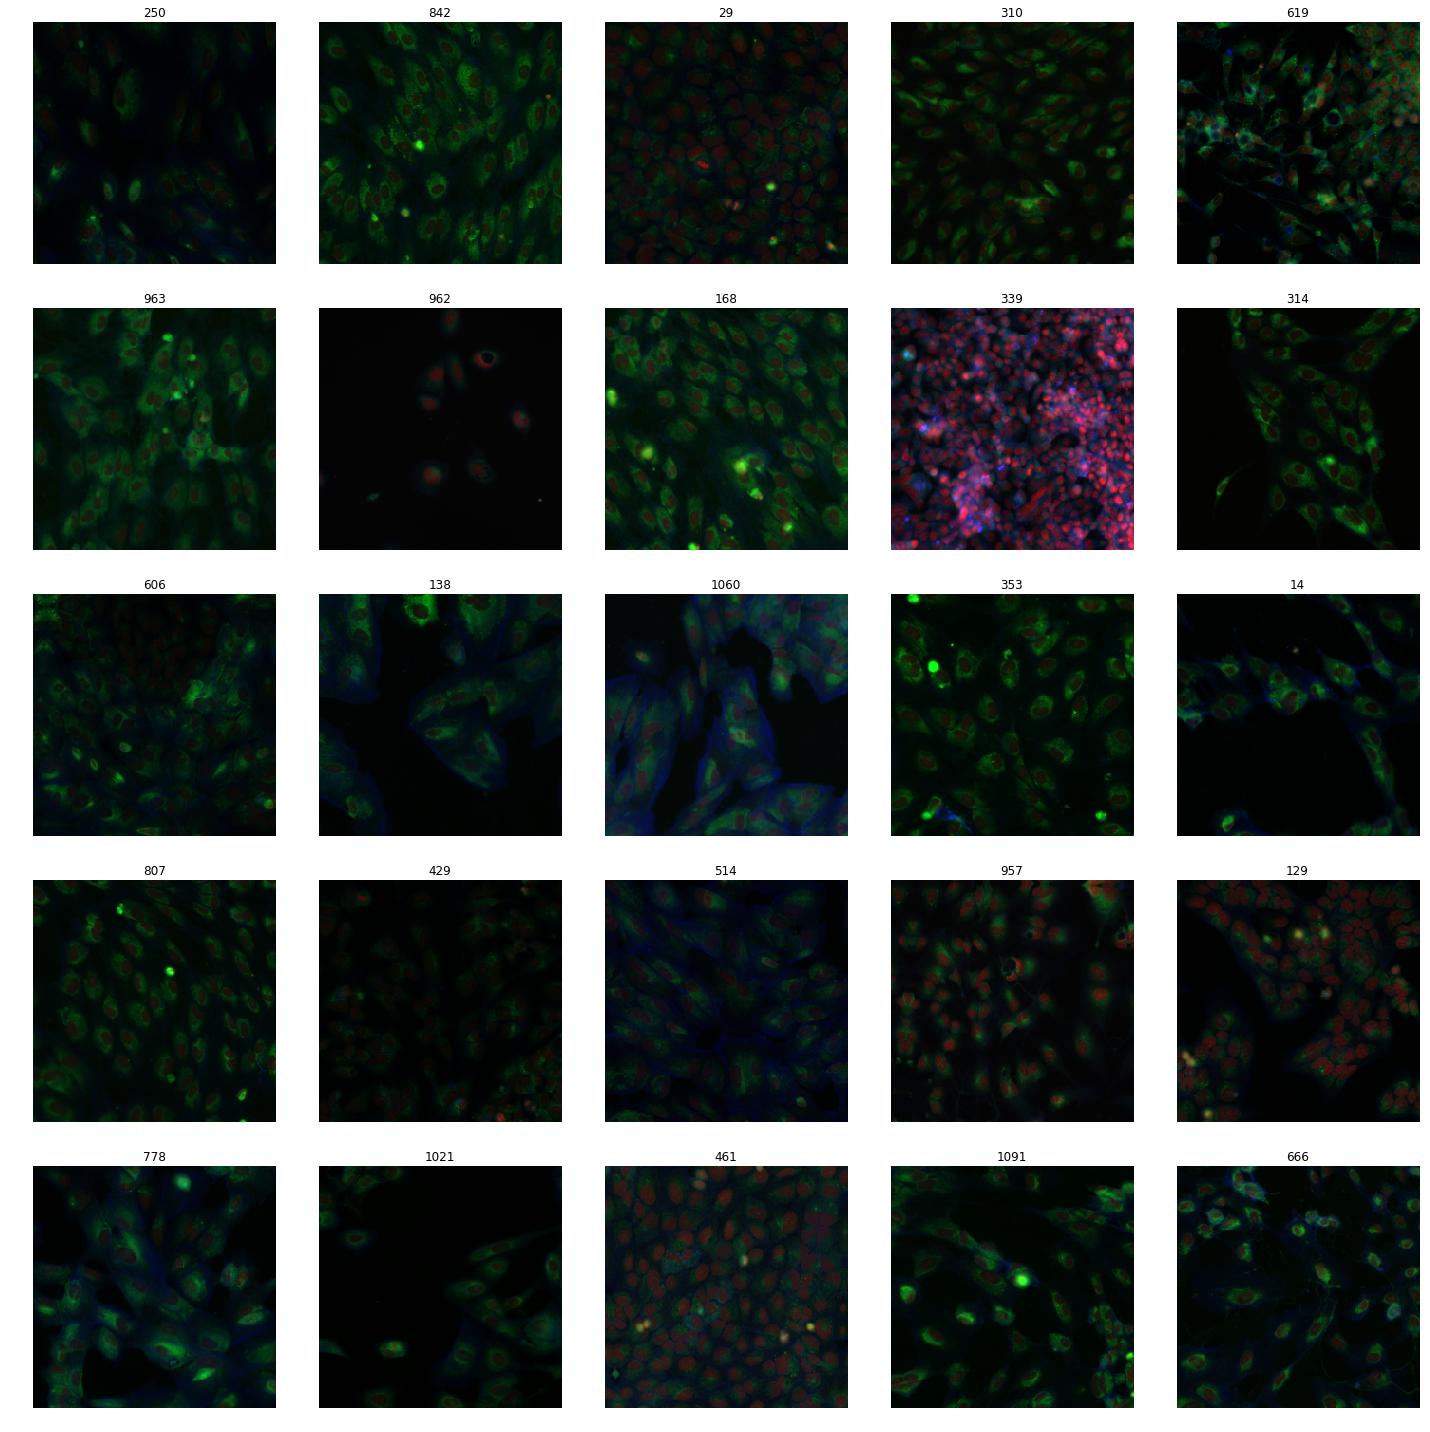

In [13]:
data.show_batch()

In [14]:
from sklearn.metrics import roc_auc_score

In [ ]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [16]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.4.0-cp36-none-any.whl size=11149 sha256=1548901d6880781cd28cfcaa3eaa2f74ca7d4933d207be0f6d8ac6f7a3684f04
  Stored in directory: /tmp/.cache/pip/wheels/27/56/13/5bdaa98ca8bd7d5da65cc741987dd14391b87fa1a09081d17a
Successfully built efficientnet-pytorch


In [23]:
from torchvision.models import *
from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [20]:

def efficientnet_multichannel(pretrained=True,name='b0',num_classes=1108,num_channels=6,image_size=256):
    model = EfficientNet.from_pretrained('efficientnet-'+name,num_classes=num_classes)
    #model.load_state_dict(torch.load(EFFICIENTNET_MODELS[name]))
    w = model._conv_stem.weight
    #s = model._conv_stem.static_padding
    #utils.Conv2dStaticSamePadding(num_channels,32,kernel_size=(3, 3), stride=(2, 2), bias=False, image_size = image_size)
    model._conv_stem = nn.Sequential(nn.Conv2d(num_channels, 32, kernel_size=(3,3), stride=(2,2), bias=False),
            nn.ZeroPad2d(padding=(0, 1, 0, 1)))
    batchnorm1 = nn.BatchNorm2d(32)
    model._conv_stem.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
    return model

In [21]:

def efficientnetb0(pretrained=True,num_channels=6):
    return efficientnet_multichannel(pretrained=pretrained,name='b0',num_channels=num_channels)

In [24]:
from fastai.metrics import *
learn = Learner(data, efficientnetb0(),metrics=[accuracy]).to_fp16()
learn.path = Path('../')

Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b0-355c32eb.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 24.4MB/s]

Loaded pretrained weights for efficientnet-b0


In [25]:
import sys
from efficientnet_pytorch import EfficientNet

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [26]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.858604,6.031287,0.035966,21:20
1,5.057511,4.919776,0.112588,21:06
2,4.307067,4.541057,0.169664,20:54


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fef0e1ebef0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fef0e1ebef0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/c

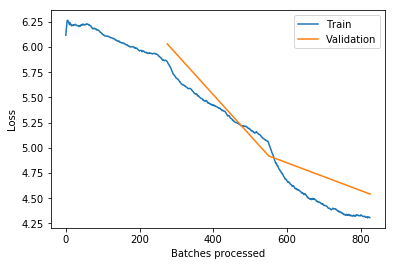

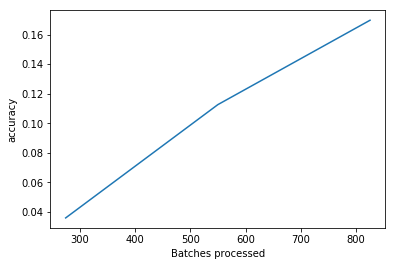

In [30]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [31]:
learn.save('stage-1')
learn.export()

In [40]:
#learn.fit_one_cycle(10,slice(1e-6,5e-4))

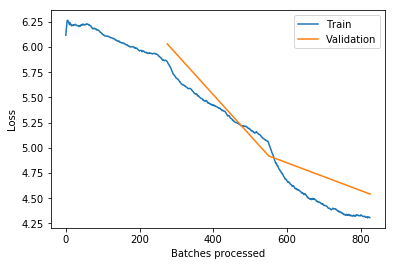

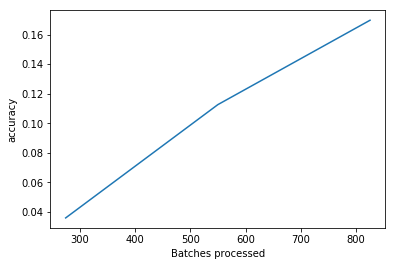

In [33]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [34]:
learn.save('stage-2')
learn.export()

In [37]:
test_df = pd.read_csv('../input/recursion-cellular-image-classification/test.csv')
proc_test_df = generate_df(test_df.copy())

In [38]:
data_test = MultiChannelImageList.from_df(df=proc_test_df,path='../input/recursion-cellular-image-classification/test/')
learn.data.add_test(data_test)

In [39]:
preds, _ = learn.get_preds(DatasetType.Test)

In [41]:
preds_ = preds.argmax(dim=-1)

In [42]:
test_df.head()

,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07


In [44]:
submission_df = pd.read_csv('../input/recursion-cellular-image-classification/sample_submission.csv')

In [45]:
submission_df.sirna = preds_.numpy().astype(int)
submission_df.head()

,id_code,sirna
0,HEPG2-08_1_B03,150
1,HEPG2-08_1_B04,171
2,HEPG2-08_1_B05,891
3,HEPG2-08_1_B06,280
4,HEPG2-08_1_B07,220


In [46]:
submission_df.to_csv('submission.csv',index=False)